In [1]:
using CairoMakie
using ColorSchemes
using DataFrames
using JSON3
using LaTeXStrings
using LinearAlgebra
using Statistics
using Unitful, UnitfulAtomic

In [2]:
# these are relative to 1 CSS px
inch = 96
pt = 4/3
cm = inch / 2.54
column_width = 9 * cm  # Single-column width

340.1574803149606

In [3]:
workdir = @__DIR__
files = filter(endswith(".json"), readdir(joinpath(workdir, "runs")))

21-element Vector{String}:
 "AlAs_b3_kgrid(13, 13, 13).json"
 "AlN_b3_kgrid(17, 17, 17).json"
 "AlP_b3_kgrid(14, 14, 14).json"
 "BAs_b3_kgrid(16, 16, 16).json"
 "BN_b3_kgrid(21, 21, 21).json"
 "BP_b3_kgrid(16, 16, 16).json"
 "C_diamond_kgrid(21, 21, 21).json"
 "CaO_b1_kgrid(15, 15, 15).json"
 "GaN_b3_kgrid(16, 16, 16).json"
 "GaP_b3_kgrid(14, 14, 14).json"
 ⋮
 "LiCl_b1_kgrid(15, 15, 15).json"
 "LiF_b1_kgrid(18, 18, 18).json"
 "LiH_b1_kgrid(19, 19, 19).json"
 "MgO_b1_kgrid(18, 18, 18).json"
 "MgS_b1_kgrid(14, 14, 14).json"
 "NaCl_b1_kgrid(13, 13, 13).json"
 "NaF_b1_kgrid(16, 16, 16).json"
 "SiC_b3_kgrid(17, 17, 17).json"
 "Si_diamond_kgrid(14, 14, 14).json"

In [4]:
function force_to_cart(forces, lattice)
    A = reshape(lattice, 3, 3)
    A_invT = inv(A')
    [A_invT * f for f in forces]
end

force_to_cart (generic function with 1 method)

In [5]:
df = DataFrame()
for file in files
    name = split(file, "_")[1]
    data = JSON3.read(read(joinpath(workdir, "runs", file), String))

    lattice = data["base"]["lattice"]
    n_electrons = data["base"]["n_electrons"]
    Ecut = data["base"]["Ecut"]
    forces = data["base"]["forces"]

    Ecut_large = data["reference"]["Ecut"]
    forces_large = data["reference"]["forces"]

    forces_base = data["refinement"]["forces_base"]
    forces_refined = data["refinement"]["forces_refined"]
    density_error_estimate = data["refinement"]["δρ_l1"]
    density_exact_error = data["refinement"]["ρ_error_l1"]
    dvol = data["refinement"]["dvol"]

    push!(df, (; name, Ecut, Ecut_large, n_electrons,
                 forces=force_to_cart(forces, lattice),
                 forces_base=force_to_cart(forces_base, lattice),
                 forces_refined=force_to_cart(forces_refined, lattice),
                 forces_large=force_to_cart(forces_large, lattice),
                 density_error_estimate, density_exact_error, dvol), promote=true)
end
df

Row,name,Ecut,Ecut_large,n_electrons,forces,forces_base,forces_refined,forces_large,density_error_estimate,density_exact_error,dvol
,SubStrin…,Int64,Float64,Int64,Array…,Array…,Array…,Array…,Float64,Float64,Float64
1,AlAs,20,72.0,18,"[[-0.00279969, -0.00464268, -0.00665494], [0.00279998, 0.00464295, 0.00665526]]","[[-0.00279969, -0.00464268, -0.00665494], [0.00279997, 0.00464293, 0.00665522]]","[[-0.00283547, -0.00490246, -0.00713218], [0.00282646, 0.00488744, 0.00711048]]","[[-0.00291033, -0.0049878, -0.00723659], [0.00291031, 0.00498779, 0.00723657]]",1034.33,1880.2,0.00121474
2,AlN,20,72.0,8,"[[-0.0027278, -0.00473422, -0.00688915], [0.0027278, 0.0047342, 0.00688912]]","[[-0.00272769, -0.00473408, -0.00688899], [0.00272763, 0.00473395, 0.00688879]]","[[-0.00269318, -0.00467948, -0.0068114], [0.00269341, 0.00467987, 0.00681195]]","[[-0.00268451, -0.00466918, -0.00679802], [0.00268451, 0.00466918, 0.00679802]]",95.1554,122.144,0.00131212
3,AlP,20,42.0,8,"[[-0.00286489, -0.00493741, -0.00717389], [0.00286487, 0.00493737, 0.00717383]]","[[-0.00286489, -0.00493741, -0.00717389], [0.00286489, 0.00493741, 0.00717389]]","[[-0.00286422, -0.00493647, -0.00717258], [0.00286422, 0.00493648, 0.00717258]]","[[-0.00286418, -0.00493641, -0.0071725], [0.00286418, 0.00493641, 0.0071725]]",0.947291,1.01345,0.00310076
4,BAs,20,72.0,18,"[[-0.00259567, -0.00463066, -0.00677912], [0.00260024, 0.00463878, 0.00679099]]","[[-0.00259567, -0.00463066, -0.00677912], [0.00260044, 0.00463913, 0.00679151]]","[[-0.00266933, -0.00489532, -0.00721615], [0.00267625, 0.00490968, 0.00723785]]","[[-0.00266294, -0.00487629, -0.00718531], [0.00266295, 0.00487629, 0.00718531]]",1057.59,1916.18,0.00119668
5,BN,20,72.0,8,"[[-0.00281095, -0.00522758, -0.00773063], [0.00281096, 0.0052276, 0.00773065]]","[[-0.00281096, -0.00522759, -0.00773063], [0.00281097, 0.00522761, 0.00773066]]","[[-0.00262583, -0.00484418, -0.00715068], [0.00262635, 0.00484516, 0.00715214]]","[[-0.00253939, -0.00467366, -0.00689518], [0.00253939, 0.00467366, 0.00689518]]",96.6412,124.053,0.0012567
6,BP,20,66.0,8,"[[-0.00261902, -0.00483523, -0.00713768], [0.00261904, 0.00483526, 0.00713773]]","[[-0.00261902, -0.00483523, -0.00713768], [0.00261903, 0.00483524, 0.00713771]]","[[-0.00261458, -0.00482816, -0.00712761], [0.00261459, 0.00482818, 0.00712764]]","[[-0.00261409, -0.00482763, -0.00712696], [0.00261409, 0.00482763, 0.00712696]]",20.0332,24.6308,0.00143864
7,C,20,67.5,8,"[[-0.00264002, -0.00509203, -0.00758541], [0.00264002, 0.00509203, 0.00758541]]","[[-0.00264002, -0.00509203, -0.00758541], [0.00264002, 0.00509203, 0.00758541]]","[[-0.0025505, -0.00488518, -0.00726704], [0.0025505, 0.00488518, 0.00726704]]","[[-0.00248852, -0.0047543, -0.00706862], [0.00248852, 0.0047543, 0.00706862]]",80.8099,103.635,0.00120225
8,CaO,20,72.0,16,"[[-0.00184037, -0.00442583, -0.00834503], [0.00183464, 0.00441821, 0.00833968]]","[[-0.00184434, -0.00442346, -0.00834548], [0.00184633, 0.00442893, 0.00834927]]","[[-0.00215948, -0.00480958, -0.00846434], [0.00216079, 0.00481308, 0.00846799]]","[[-0.00237543, -0.00514856, -0.00874199], [0.00237543, 0.00514856, 0.008742]]",188.549,247.505,0.0012244
9,GaN,20,72.0,18,"[[-0.00378421, -0.00654582, -0.00950427], [0.00382362, 0.00666309, 0.00975145]]","[[-0.00378823, -0.00654333, -0.00949382], [0.00382339, 0.0066627, 0.0097509]]","[[-0.00294807, -0.00508365, -0.00736174], [0.00308584, 0.005172, 0.00746654]]","[[-0.00284751, -0.00474692, -0.00683633], [0.00284751, 0.00474693, 0.00683633]]",771.653,1217.18,0.00131714


In [6]:
for (; name, Ecut, Ecut_large, forces, forces_base, forces_refined, forces_large) in eachrow(df)
    error = maximum(norm, forces_large - forces)
    error_after_refinement = maximum(norm, forces_large - forces_refined)
    println(name)
    println(error)
    println(error_after_refinement)
end

AlAs
0.0006853206797909009
0.00018165728918490643
AlN
0.00012003752901475071
1.9683028762605217e-5
AlP
1.8505513978532422e-6
1.1493576751466642e-7
BAs
0.00047942721074764827
6.365749656335623e-5
BN
0.0010385648258835495
0.0003209498164813483
BP
1.4088453427725069e-5
1.0078441277852984e-6
C
0.0006356779462595888
0.0002456481376006483
CaO
0.000993847553988054
0.0004884993187280245
GaN
0.003622481327563929
0.0007966437998297525
GaP
0.0003262397611274606
0.00018228409333340638
InAs
0.001600807891101543
0.00026890945934649526
InP
8.758804561551168e-5
2.621295147332147e-5
LiCl
0.00010170886527749161
7.358318877496958e-5
LiF
0.0008903107586335466
0.0002958752372327644
LiH
0.00017853513600780851
4.877564749447611e-5
MgO
0.0073460048879277874
0.0036297110142151103
MgS
0.00027916514527214636
0.0004442283352142102
NaCl
0.0006631054931312304
0.0005012885253057862
NaF
0.007510684510152463
0.0029198328454058966
SiC
8.855907018745763e-5
1.844320503751794e-5
Si
5.180485792774795e-7
3.006299124722095e-

In [ ]:
TARGET_FORCE_MAGNITUDE = 0.5 # eV/Å

system_rescalings = []

for (; name, Ecut, Ecut_large, forces, forces_base, forces_refined, forces_large) in eachrow(df)
    RATIO = ustrip(u"eV/Å", 1u"hartree/bohr")
    forces_norm = RATIO * maximum(norm, forces_large)
    push!(system_rescalings, Dict("name" => name, "rescaling" => TARGET_FORCE_MAGNITUDE / forces_norm))
end

for d in system_rescalings
    if 0.8 ≤ d["rescaling"] ≤ 1.2
        continue
    end
    println("System: $(d["name"]), rescaling: $(d["rescaling"])")
end

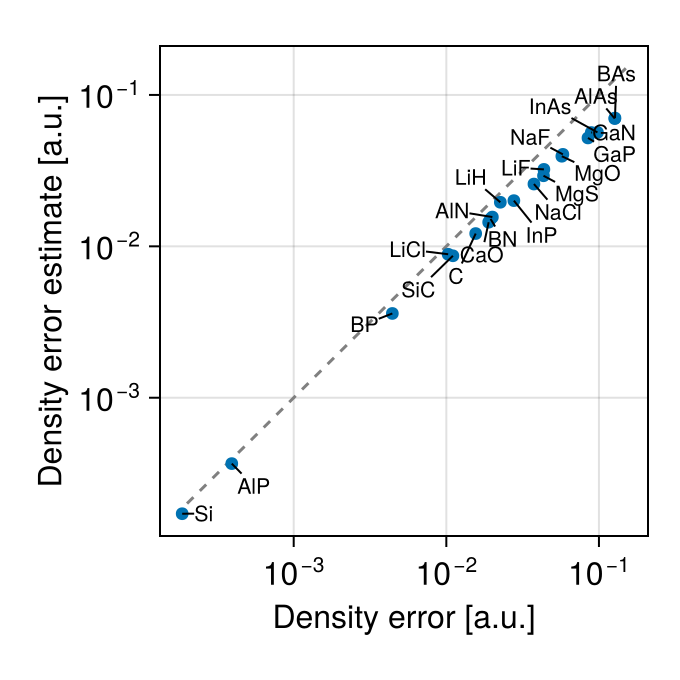

In [8]:
fig = Figure(size=(column_width, column_width), fontsize=12pt)
ax = Makie.Axis(fig[1,1],
                xlabel="Density error [a.u.]",
                ylabel="Density error estimate [a.u.]",
                aspect=1, #title="Density error estimates, Ecut=20 Ha",
                xscale=log10, yscale=log10)
lims = [2e-4, 1.5e-1]
lines!(lims, lims, color=:gray, linestyle=:dash)

# (error, error estimate, name)
points = []

errors = []
error_estimates = []
names = []

for (; name, Ecut, Ecut_large, density_error_estimate, density_exact_error, dvol, n_electrons) in eachrow(df)
    error = density_exact_error * dvol / n_electrons
    error_estimate = density_error_estimate * dvol / n_electrons
    push!(errors, error)
    push!(error_estimates, error_estimate)
    push!(names, name)
end

scatter!(ax, errors, error_estimates)
annotation!(ax, errors, error_estimates; text=names, fontsize=8pt, shrink=(0,0))

save("pw_error_estimation_density.pdf", fig)

fig

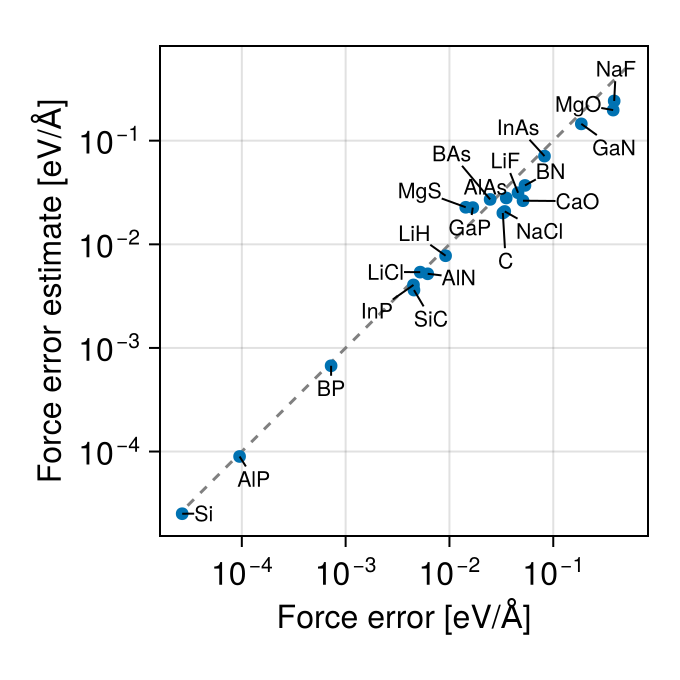

In [9]:
fig = Figure(size=(column_width, column_width), fontsize=12pt)
ax = Makie.Axis(fig[1,1],
                xlabel="Force error [eV/Å]",
                ylabel="Force error estimate [eV/Å]",
                aspect=1, #title="Absolute estimates, Ecut=20 Ha, eV/Å",
                xscale=log10, yscale=log10)
lims = [3e-5, 0.5]
lines!(lims, lims, color=:gray, linestyle=:dash)

errors = []
error_estimates = []
names = []

for (; name, Ecut, Ecut_large, forces, forces_base, forces_refined, forces_large) in eachrow(df)
    RATIO = ustrip(u"eV/Å", 1u"hartree/bohr")
    error = RATIO * maximum(norm, forces_large - forces)
    error_estimate = RATIO * maximum(norm, forces_refined - forces_base)
    push!(errors, error)
    push!(error_estimates, error_estimate)
    push!(names, name)
end

scatter!(ax, errors, error_estimates)
annotation!(ax, errors, error_estimates; text=names, fontsize=8pt, shrink=(0,0))

save("pw_error_estimation_force.pdf", fig)

fig